# <a id='toc1_'></a>[HCDN Elevation Bands Cumulative Distribution](#toc0_)
Daniel Hogan
Summer 2023

This notebook will work to look at changes in the cumulative distribution of daily streamflow between the Millennium Drought and Baseline periods.

**Table of contents**<a id='toc0_'></a>    
- [HCDN Elevation Bands Cumulative Distribution](#toc1_)    
  - [Figure for Normal Daily Flow for each basin by elevation grouping](#toc1_1_)    
  - [Figure for Normal Daily Flow for each basin by response timing grouping](#toc1_2_)    
  - [Figure for Grouping Average](#toc1_3_)    
  - [Figure for Representative Basin and Difference between CDFs](#toc1_4_)    
    - [Plot for comparing streamflow volumes](#toc1_4_1_)    
- [Calculate additional metrics for summer precipitation changes](#toc2_)    
    - [Look to see if summer streamflow variability is decreasing](#toc2_1_1_)    
    - [Using Thortwaithe method for monthly ET estimates](#toc2_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import datetime as dt
import scipy.stats as stats

In [2]:
# Pull in hcdn_q_data from streamflowdata folder
hcdn_q_data = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')

# add a water year variable to the dataset
hcdn_q_data['water_year'] = hcdn_q_data.date.dt.year.where(hcdn_q_data.date.dt.month >= 10, hcdn_q_data.date.dt.year - 1)

# create a function to calculate the day of water year for each date in the dataset
def day_of_water_year_func(date):
    if date.month >= 10:
        return (date - pd.to_datetime(str(date.year) + '-10-01')).days + 1
    else:
        return (date - pd.to_datetime(str(date.year - 1) + '-10-01')).days + 1

# apply the function to the date variable to create a new variable
day_of_water_year = [day_of_water_year_func(date) for date in pd.to_datetime(hcdn_q_data.date.values)]

# add the day of water year variable to the dataset
hcdn_q_data['day_of_water_year'] = xr.DataArray(day_of_water_year, dims=['date'], coords={'date': hcdn_q_data.date})
                                                

In [3]:
# calculate the day of water year flow at each site
water_year_mean_flow = hcdn_q_data.where((hcdn_q_data.date.dt.date>dt.date(1963,10,1)) & 
                                           ( hcdn_q_data.date.dt.date<dt.date(2022,10,1))).groupby('day_of_water_year').mean()['q_mm_day']


In [4]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# merge basin_group_da into water_year_mean_flow
water_year_mean_flow = water_year_mean_flow.to_dataset(name='flow').merge(basin_group_da)

In [5]:
# calculate the mean flow for each predicted cluster and day of water year
water_year_cluster_flow = water_year_mean_flow.where(~water_year_mean_flow.site_no.isin(['09110000','09183500']),drop=True).groupby('predicted_cluster').mean()

# change the predicted_cluster values from 0,1,2 to mid, low, high
water_year_cluster_flow['predicted_cluster'] = ['mid', 'low', 'high']

# change the order of predicted_cluster to low, mid, high
water_year_cluster_flow = water_year_cluster_flow.reindex({'predicted_cluster':['low', 'mid', 'high']})

## <a id='toc1_1_'></a>[Figure for Normal Daily Flow for each basin by elevation grouping](#toc0_)

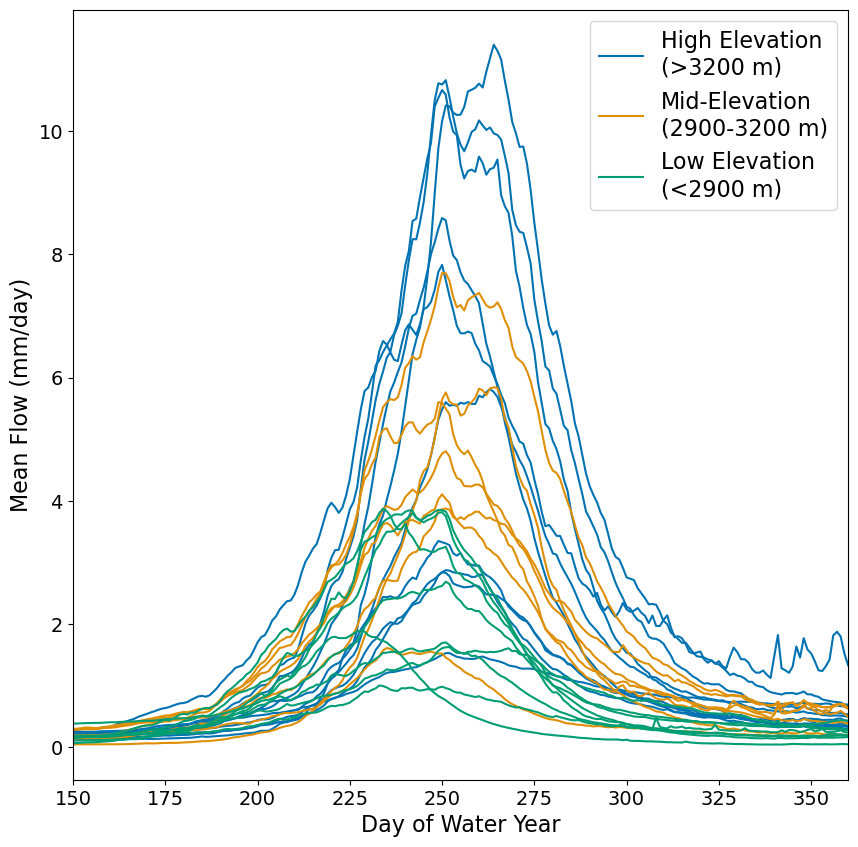

In [6]:
# create a figure and axis
fig, ax = plt.subplots(figsize=(10,10))
# plot each of the sites in water_year_mean_flow with each cluster having a different color
c = ['Mid-Elevation\n(2900-3200 m)', 'Low Elevation\n(<2900 m)', 'High Elevation\n(>3200 m)']
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster))
for j,cluster in enumerate([2,0,1]):
    tmp_ds = water_year_mean_flow.where(water_year_mean_flow.predicted_cluster==cluster)
    for i,site in enumerate(tmp_ds.site_no.values):
        if tmp_ds.sel(site_no=site).flow.sum()<100 :
            if i == 0:
                ax.plot([],[], label=c[cluster], color=colors[j])
            continue
        elif i == 0:
            tmp_ds.sel(site_no=site).flow.plot(ax=ax, label=c[cluster], color=colors[j])
        else:
            tmp_ds.sel(site_no=site).flow.plot(ax=ax, color=colors[j])
# Set the x and y axis labels
ax.set_xlabel('Day of Water Year', size=16)
ax.set_ylabel('Mean Flow (mm/day)', size=16)
# Set the title
# ax.set_title('Mean Daily Flow by Day of Water Year for Basin Elevation Groups', size=18)
ax.set_title('')
# Add a legend for each of the colors
ax.legend(fontsize=16)
# set the xlim to 150-360
ax.set_xlim(150,360)
# set the x and y tick size to 14
ax.tick_params(labelsize=14)

## <a id='toc1_2_'></a>[Figure for Normal Daily Flow for each basin by response timing grouping](#toc0_)

In [7]:
fast_response_basins = ['09034900', '09065500', '09066200', '09066300', '09081600', '09112500',
       '09124500', '09132500', '09146200', '09147500', '09165000', '09210500',
       '09223000', '09239500', '09312600', '09352900', '09361500', '09066000']
slow_response_basins = ['09035900', '09047700', '09107000', '09110000', '09115500',
       '09119000', '09183500', '09304500']

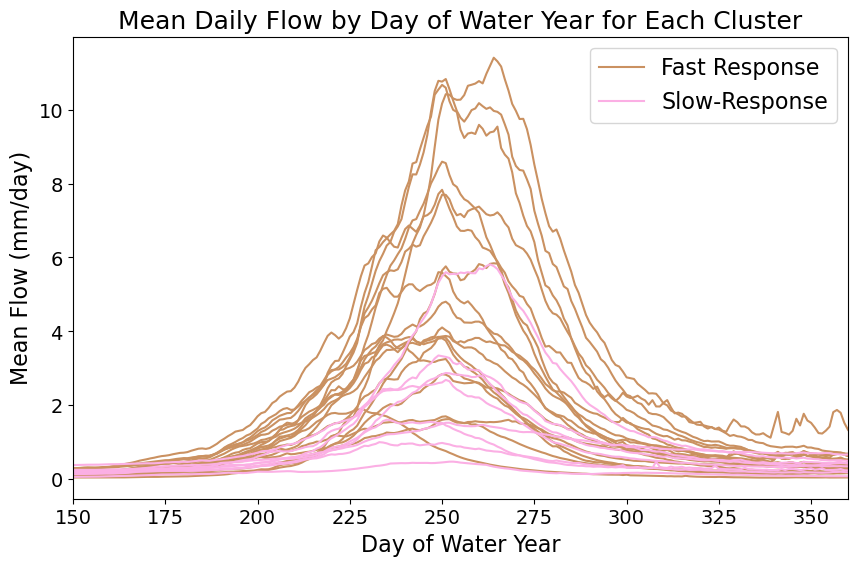

In [8]:
# create a figure and axis
fig, ax = plt.subplots(figsize=(10,6))
# plot each of the sites in water_year_mean_flow with each cluster having a different color
c = ['Fast Response','Slow-Response']
colors = sns.color_palette('colorblind')[5:7]
for j,cluster in enumerate([fast_response_basins,slow_response_basins]):
    tmp_ds = water_year_mean_flow.where(water_year_mean_flow.site_no.isin(cluster))
    for i,site in enumerate(tmp_ds.site_no.values):
        if i == 0:
            tmp_ds.sel(site_no=site).flow.plot(ax=ax, label=c[j], color=colors[j])
        else:
            tmp_ds.sel(site_no=site).flow.plot(ax=ax, color=colors[j])
# Set the x and y axis labels
ax.set_xlabel('Day of Water Year', size=16)
ax.set_ylabel('Mean Flow (mm/day)', size=16)
# Set the title
ax.set_title('Mean Daily Flow by Day of Water Year for Each Cluster', size=18)
# Add a legend for each of the colors
ax.legend(fontsize=16)
# set the xlim to 150-360
ax.set_xlim(150,360)
# set the x and y tick size to 14
ax.tick_params(labelsize=14)

## <a id='toc1_3_'></a>[Figure for Grouping Average](#toc0_)

(180.0, 300.0)

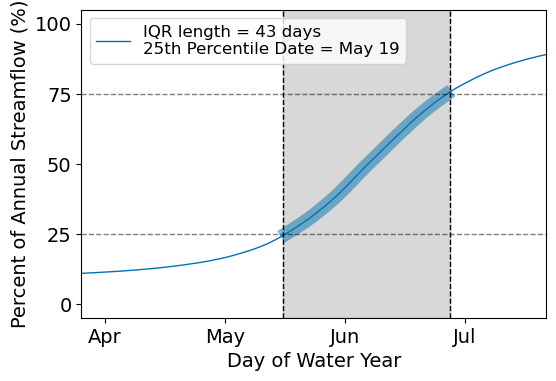

In [9]:
# create the figure
fig = plt.figure(figsize=(6,4))
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster))

for i,site in enumerate([2]):
    tmp_ds = (water_year_cluster_flow['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow['flow'].sum(dim='day_of_water_year') * 100).isel(predicted_cluster=site)
    # find the day of water year for the 25th percentile
    iqr_25_index = tmp_ds.where(tmp_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index = tmp_ds.where(tmp_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # Initializing start date
    strt_date = dt.date(int(2020), 1, 1)
    
    # converting to date
    res_date = strt_date + dt.timedelta(days=int(iqr_25_index-92) - 1)
    res = res_date.strftime("%b %d")

    # plot the cumulative distribution
    # tmp_ds.plot(label=f'{str(water_year_cluster_flow.predicted_cluster.values[site]).upper()} - IQR length = {int(iqr_75_index - iqr_25_index)} days\n25th Percentile Date = {res}', color=colors[i], lw=1)
    tmp_ds.plot(label=f'IQR length = {int(iqr_75_index - iqr_25_index)} days\n25th Percentile Date = {res}', color=colors[i], lw=1)
    # create a filter for the inter quartile range
    iqr_filter = (tmp_ds >= 25) & (tmp_ds <= 75)
    # add a wider line for the interquartile range
    tmp_ds.where(iqr_filter, drop=True).plot(lw=10, alpha=0.5,color=colors[i],)
    # add horizontal line at 25th and 75th percentile
    plt.axhline(25, color='k', lw=1, ls='--', alpha=0.5)
    plt.axhline(75, color='k', lw=1, ls='--', alpha=0.5)
    
# make the x-axis a an axis of months
plt.xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'], size=14);
# add vspan between april and july
# plt.axvspan(31+30+31+31+29+31+2, 31+30+31+31+29+31+30+31+30+4, alpha=0.3, color='yellow')
plt.axvline(iqr_25_index, color='k', lw=1, ls='--', alpha=1)
plt.axvline(iqr_75_index, color='k', lw=1, ls='--', alpha=1)
plt.axvspan(iqr_25_index, iqr_75_index, alpha=0.3, color='grey',zorder=0)
# increase y-tick size
plt.yticks(size=14)
# make the y-axis a percentage
plt.ylabel('Percent of Annual Streamflow (%)', size=14)
# remove the x-label
plt.xlabel('Day of Water Year', size=14)
# make the title "Cumulative Distribution of Annual Streamflow"
# plt.title('Baseline Period (1964-1999)', size=14)
plt.title('')
plt.legend(fontsize=12)
# make yticks 0,25,50,75,100
plt.yticks([0,25,50,75,100])
plt.xlim(180,300)

In [10]:
# calculate the day of water year flow at each site for pre- and post- 2000
water_year_mean_flow_pre_2000 = hcdn_q_data.where((hcdn_q_data.date.dt.year < 2000) & (hcdn_q_data.date.dt.year >=1964), drop=True).groupby('day_of_water_year').mean()['q_mm_day']
water_year_mean_flow_post_2000 = hcdn_q_data.where(hcdn_q_data.date.dt.year >= 2000, drop=True).groupby('day_of_water_year').mean()['q_mm_day']

# merge basin_group_da into water_year_mean_flow_pre_2000 and water_year_mean_flow_post_2000
water_year_mean_flow_pre_2000 = water_year_mean_flow_pre_2000.to_dataset(name='flow').merge(basin_group_da)
water_year_mean_flow_post_2000 = water_year_mean_flow_post_2000.to_dataset(name='flow').merge(basin_group_da)

# calculate the mean flow for each predicted cluster and day of water year for pre and post 2000
water_year_cluster_flow_pre_2000 = water_year_mean_flow_pre_2000.groupby('predicted_cluster').mean()
water_year_cluster_flow_post_2000 = water_year_mean_flow_post_2000.groupby('predicted_cluster').mean()

# change the predicted_cluster values from 1,0,2 to mid, low, high
water_year_cluster_flow_pre_2000['predicted_cluster'] = ['mid', 'low', 'high']
water_year_cluster_flow_post_2000['predicted_cluster'] = ['mid', 'low', 'high']

# change the order of predicted_cluster to low, mid, high
water_year_cluster_flow_pre_2000 = water_year_cluster_flow_pre_2000.reindex(predicted_cluster=['low', 'mid', 'high'])
water_year_cluster_flow_post_2000 = water_year_cluster_flow_post_2000.reindex(predicted_cluster=['low', 'mid', 'high'])

Text(-0.02, 0.5, 'Percent of Annual Streamflow (%)')

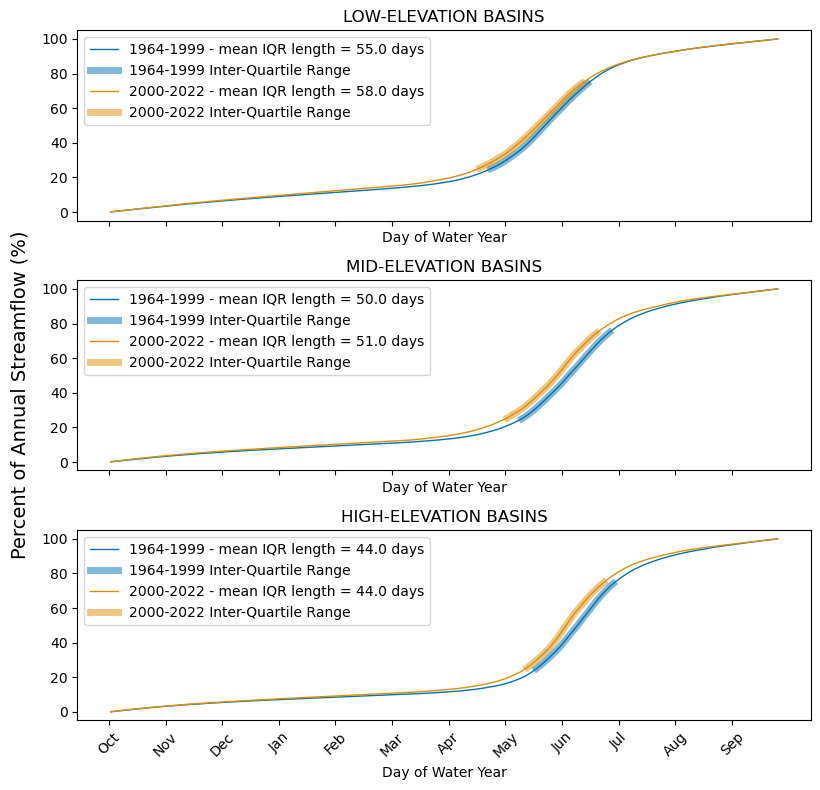

In [11]:
# create the figure
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster)+1)

for i,site in enumerate(water_year_cluster_flow_pre_2000.predicted_cluster):
    tmp_pre_ds = (water_year_cluster_flow_pre_2000['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow_pre_2000['flow'].sum(dim='day_of_water_year') * 100).sel(predicted_cluster=site)
    tmp_post_ds = (water_year_cluster_flow_post_2000['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow_post_2000['flow'].sum(dim='day_of_water_year') * 100).sel(predicted_cluster=site)
    
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # create a filter for the inter quartile range
    iqr_pre_filter = (tmp_pre_ds >= 25) & (tmp_pre_ds <= 75)
    iqr_post_filter = (tmp_post_ds >= 25) & (tmp_post_ds <= 75) 
    
    # plot the 1964-1999 and 2000-2022 cumulative distribution
    tmp_pre_ds.plot(label=f'1964-1999 - mean IQR length = {iqr_75_index_pre - iqr_25_index_pre} days', color=colors[0], lw=1, ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_pre_ds.where(iqr_pre_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[0], ax=axs[i], label='1964-1999 Inter-Quartile Range')
    
    tmp_post_ds.plot(label=f'2000-2022 - mean IQR length = {iqr_75_index_post - iqr_25_index_post} days', lw=1, color=colors[1], ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_post_ds.where(iqr_post_filter, drop=True).plot(lw=5, alpha=0.5, color=colors[1], ax=axs[i], label='2000-2022 Inter-Quartile Range')


    
    # make the x-axis a an axis of months
    axs[i].set_xticks(np.arange(0,366,31))
    axs[i].set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'])
    # rotate the x-axis labels 45 degrees
    axs[i].tick_params(axis='x', rotation=45)
    # make the y-axis a percentage
    axs[i].set_ylabel('')
    # set x-label
    axs[i].set_xlabel('Day of Water Year')
    # set title to the predicted cluster
    axs[i].set_title(f'{water_year_cluster_flow_pre_2000.predicted_cluster.values[i].upper()}-ELEVATION BASINS')
    # add legend
    axs[i].legend(loc='upper left')
# create a shared y-axis label
fig.text(-0.02, 0.5, 'Percent of Annual Streamflow (%)', va='center', rotation='vertical', size=14)

## <a id='toc1_4_'></a>[Figure for Representative Basin and Difference between CDFs](#toc0_)

In [12]:
high_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09035900').flow # Lake Fork Basin
high_name = 'South Fork of Williams Fork (Gage ID: 09035900)'
mid_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09112500').flow # East River Basin
mid_name = 'East River Basin (Gage ID: 09112500)'
low_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09132500').flow 
low_name = 'North Fork Gunnison River Basin (Gage ID: 09132500)'

high_example_post = water_year_mean_flow_post_2000.sel(site_no='09035900').flow # Lake Fork Basin
mid_example_post = water_year_mean_flow_post_2000.sel(site_no='09112500').flow # East River Basin
low_example_post = water_year_mean_flow_post_2000.sel(site_no='09132500').flow # Uncompahgre River Basin Above Colona

Text(0.5, 0.98, 'Daily Water Year Mean Flow')

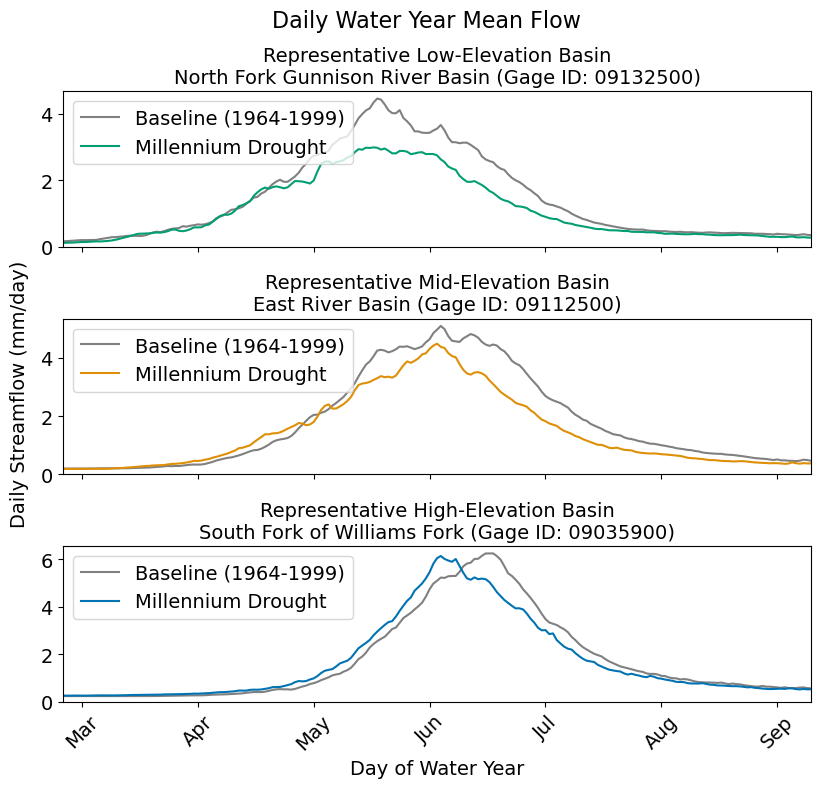

In [13]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)

ax = axs[2]
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
high_example_post.plot(ax=ax, label='Millennium Drought', color=colors[0])

# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative High-Elevation Basin\n{high_name}', size=14)

ax = axs[1]
# Plot the high example pre and post data
mid_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
mid_example_post.plot(ax=ax, label='Millennium Drought', color=colors[1])
# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('')
# set the title
ax.set_title(f'Representative Mid-Elevation Basin\n{mid_name}', size=14)

ax = axs[0]
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
# find the center of mass of high_example_pre
low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
low_example_post.plot(ax=ax, label='Millennium Drought', color=colors[2])

# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('', size=14)
# set the title
ax.set_title(f'Representative Low-Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    ax.set_ylim(0,)
    ax.set_xlim(150,350)
    ax.legend(loc='upper left')
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # increase the size of legend entries
    ax.legend(fontsize=14, loc='upper left')
    # increase the size of the x and y labels
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
fig.suptitle('Daily Water Year Mean Flow', size=16)

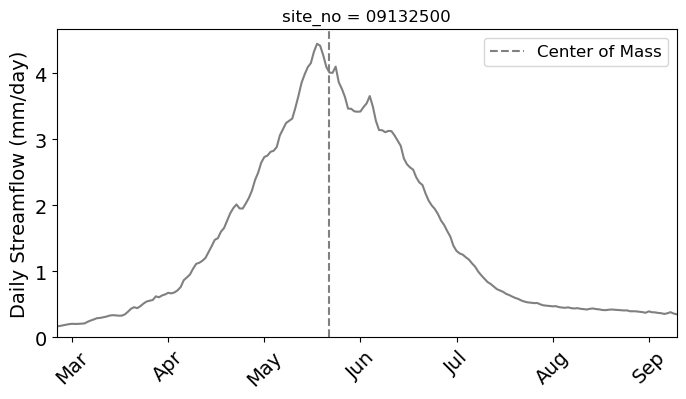

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, color='grey')
# find the center of mass of high_example_pre
low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(low_pre_com, color='grey', linestyle='--', label='Center of Mass')


# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('', size=14)
# set the title
# ax.set_title(f'Representative Low-Elevation Basin\n{low_name}', size=14)
ax.set_ylabel('Daily Streamflow (mm/day)', size=14)

ax.set_ylim(0,)
ax.set_xlim(150,350)
ax.legend(loc='upper right',ncol=1,fontsize=12,)
# increase the font size of x and y ticks
ax.tick_params(axis='both', which='major', labelsize=14)
    # increase the size of the x and y labels

Text(0.5, 0.98, 'Center of Mass Change')

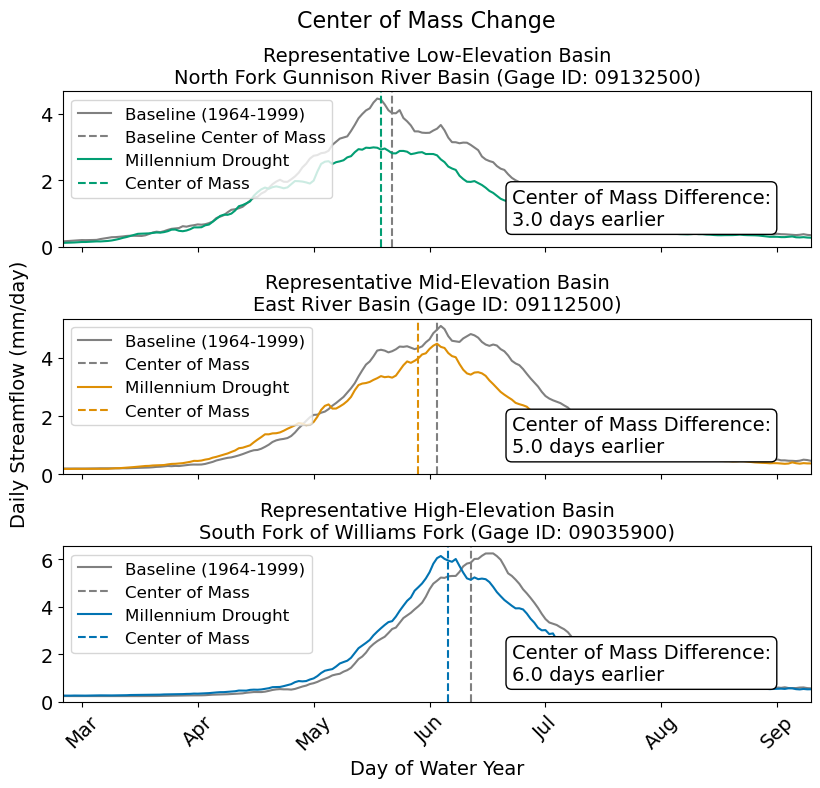

In [15]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)

ax = axs[2]
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
high_pre_com = np.abs(high_example_pre.cumsum()/high_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(high_pre_com, color='grey', linestyle='--', label='Center of Mass')

high_example_post.plot(ax=ax, label='Millennium Drought', color=colors[0])
# find the center of mass of high_example_post
high_post_com = np.abs(high_example_post.cumsum()/high_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(high_post_com-high_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(high_post_com, color=colors[0], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative High-Elevation Basin\n{high_name}', size=14)

ax = axs[1]
# Plot the high example pre and post data
mid_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
mid_pre_com = np.abs(mid_example_pre.cumsum()/mid_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(mid_pre_com, color='grey', linestyle='--', label='Center of Mass')

mid_example_post.plot(ax=ax, label='Millennium Drought', color=colors[1])
# find the center of mass of high_example_post
mid_post_com = np.abs(mid_example_post.cumsum()/mid_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(mid_post_com-mid_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(mid_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('')
# set the title
ax.set_title(f'Representative Mid-Elevation Basin\n{mid_name}', size=14)

ax = axs[0]
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(low_pre_com, color='grey', linestyle='--', label='Baseline Center of Mass')

low_example_post.plot(ax=ax, label='Millennium Drought', color=colors[2])
# find the center of mass of high_example_post
low_post_com = np.abs(low_example_post.cumsum()/low_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(low_post_com-low_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(low_post_com, color=colors[2], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('', size=14)
# set the title
ax.set_title(f'Representative Low-Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    # set the x-axis to months
    ax.set_xticks(np.arange(0,366,31))
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    ax.set_ylim(0,)
    ax.set_xlim(150,350)
    ax.legend(loc='upper left',ncol=1,fontsize=12,)
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # increase the size of the x and y labels
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
fig.suptitle('Center of Mass Change', size=16)


### <a id='toc1_4_1_'></a>[Plot for comparing streamflow volumes](#toc0_)

Pull in snow melt data

In [18]:
# pull in snowmelt stats from snowmelt_dates.ipynb
example_basin_sm_stats = pd.read_csv('../data/snowdata/example_basin_snow_stats.csv', index_col=0)
# add a 0 in from of the index values and convert to string
example_basin_sm_stats.index = ['0'+str(i) for i in example_basin_sm_stats.index]
# add a column titled elv_grp to example_basin_sm_stats with high, mid, and low values
example_basin_sm_stats['elv_grp'] = ['high','mid','low']
example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='high']['median'].values

array([165.])

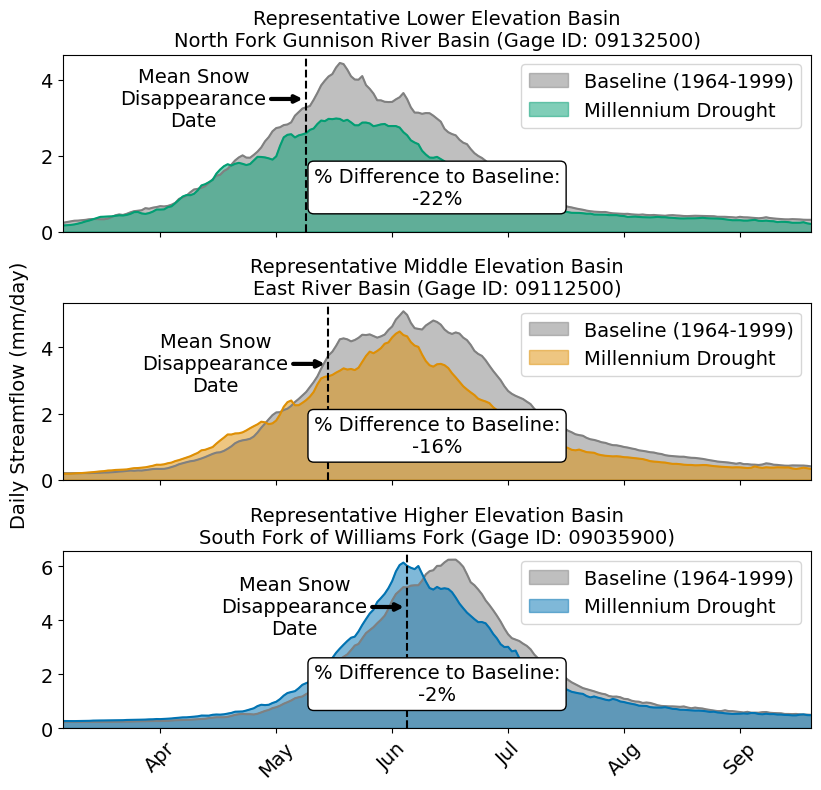

In [21]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster))

################## High Elevation Basin ##################
ax = axs[2]
# mean snowmelt dat
high_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='high']['mean'].values+91
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, color='grey')
# fill between high_example_pre 
ax.fill_between(high_example_pre.day_of_water_year, high_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

high_example_post.plot(ax=ax, color=colors[0])
# fill between high_example_pre 
ax.fill_between(high_example_post.day_of_water_year, high_example_post.values, color=colors[0], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
ax.axvline(high_melt_date, color='black', linestyle='--')

# add text and an arrow to the mean of nfg_snow_melt_doy
ax.text(high_melt_date-30, 4.5, 
        'Mean Snow\nDisappearance\nDate', 
        fontsize=14, 
        verticalalignment='center', 
        horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(high_melt_date, 4.5), xytext=(high_melt_date-10, 4.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))

# Plot center of mass
# find the center of mass of high_example_pre
# high_pre_com = np.abs(high_example_pre.cumsum()/high_example_pre.sum() - 0.50).idxmin().values
# find the center of mass of high_example_post
# high_post_com = np.abs(high_example_post.cumsum()/high_example_post.sum() - 0.50).idxmin().values

# plot a vertical line at the center of mass
# ax.axvline(high_pre_com, color='grey', linestyle='--', label='Center of Mass')
# # add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(high_post_com-high_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(high_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25,'% Difference to Baseline:\n{:.0f}%'.format(int(100*(high_example_post.sum() - high_example_pre.sum())/high_example_pre.sum())),
        horizontalalignment='center',fontsize=14,
        verticalalignment='center',
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative Higher Elevation Basin\n{high_name}', size=14)

################## Middle Elevation Basin ##################
ax = axs[1]
# mean snowmelt date
mid_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='mid']['mean'].values+91
## Plot the high example pre and post data
mid_example_pre.plot(ax=ax, color='grey')
# fill between low_eexample_pre 
ax.fill_between(mid_example_pre.day_of_water_year, mid_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

mid_example_post.plot(ax=ax, color=colors[1])
# fill between mid_example_pre 
ax.fill_between(mid_example_post.day_of_water_year, mid_example_post.values, color=colors[1], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
# ax.axvline(er_snow_melt_doy.dowy.mean(), color='black', linestyle='--')
ax.axvline(mid_melt_date, color='black', linestyle='--')
# add text and an arrow to the mean of nfg_snow_melt_doy
ax.text(mid_melt_date-30, 3.5, 'Mean Snow\nDisappearance\nDate', fontsize=14, verticalalignment='center', horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(mid_melt_date, 3.5), xytext=(mid_melt_date-10, 3.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))

# plot Center of mass
# find the center of mass of high_example_pre
# mid_pre_com = np.abs(mid_example_pre.cumsum()/mid_example_pre.sum() - 0.50).idxmin().values
# find the center of mass of high_example_post
# mid_post_com = np.abs(mid_example_post.cumsum()/mid_example_post.sum() - 0.50).idxmin().values

# plot a vertical line at the center of mass
# ax.axvline(mid_pre_com, color='grey', linestyle='--', label='Center of Mass')
# add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(mid_post_com-mid_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(mid_post_com, color=colors[1], linestyle='--', label='Center of Mass')


# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25, '% Difference to Baseline:\n{:.0f}%'.format(int(100*(mid_example_post.mean() - mid_example_pre.mean())/mid_example_pre.mean())),
        horizontalalignment='center',fontsize=14,
        verticalalignment='center',
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

# set the title
ax.set_title(f'Representative Middle Elevation Basin\n{mid_name}', size=14)

################## Lower Elevation Basin ##################
ax = axs[0]
# mean snowmelt date
low_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='low']['mean'].values+91
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, color='grey')
# fill between low_example_pre 
ax.fill_between(low_example_pre.day_of_water_year, low_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

low_example_post.plot(ax=ax, color=colors[2])
# fill between low_example_post 
ax.fill_between(low_example_post.day_of_water_year, low_example_post.values, color=colors[2], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
# ax.axvline(nfg_snow_melt_doy.dowy..mean(), color='black', linestyle='--')

ax.axvline(low_melt_date, color='black', linestyle='--')
ax.text(low_melt_date-30, 3.5, 'Mean Snow\nDisappearance\nDate',fontsize=14, verticalalignment='center', horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(low_melt_date, 3.5), xytext=(low_melt_date-10, 3.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))


# Plot center of mass
# find the center of mass of high_example_pre
# low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
# ax.axvline(low_pre_com, color='grey', linestyle='--', label='Center of Mass')

# find the center of mass of high_example_post
# low_post_com = np.abs(low_example_post.cumsum()/low_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(low_post_com-low_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(low_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25, '% Difference to Baseline:\n{:.0f}%'.format(int(100*(low_example_post.mean() - low_example_pre.mean())/low_example_pre.mean())),
        transform=ax.transAxes, fontsize=14,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

# set the title
ax.set_title(f'Representative Lower Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    ax.legend(loc='upper left')
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # rotate the x-axis labels 45 degrees
    ax.tick_params(axis='x', rotation=45)
    # set the x-axis to months
    ax.set_xticks(np.arange(0,366,31))
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    # set the y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('', size=14)
    # increase the size of legend entries
    ax.legend(fontsize=14, loc='upper right')
    # hide y axis ticks and labels
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)   
    ax.set_ylim(0,)
    ax.set_xlim(160,360)
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
# add white facecolor
fig.patch.set_facecolor('white')
# fig.suptitle('Streamflow Volume Change', size=14)
fig.savefig('../figures/streamflow_change.png', dpi=700, pad_inches=0.2, bbox_inches='tight')

Text(-0.02, 0.5, 'Percent of Annual Streamflow (%)')

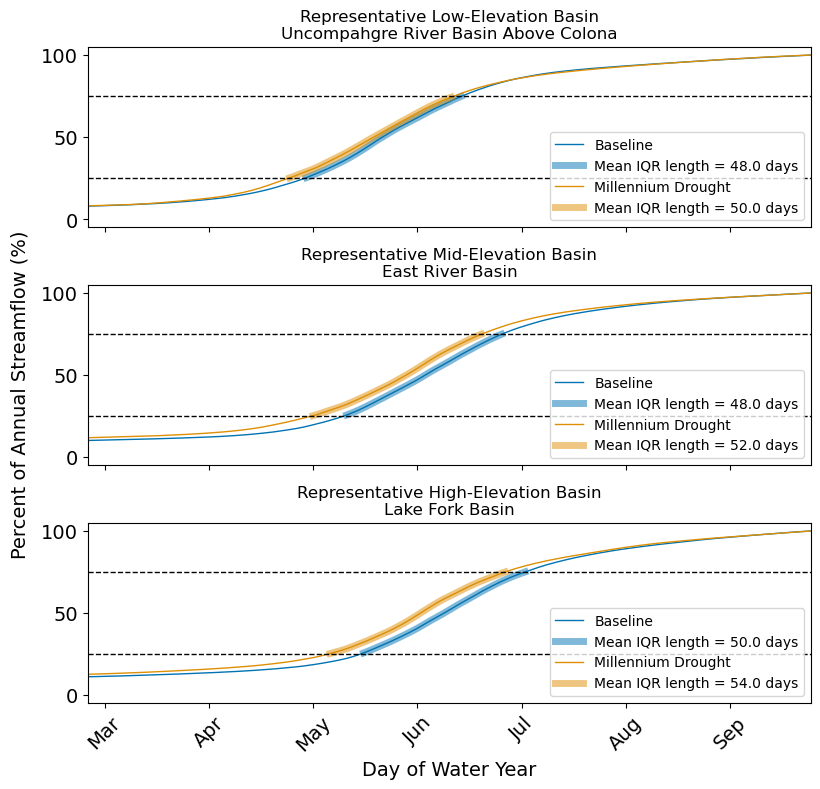

In [118]:
# create the figure
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster)+1)
# create a list of mid-elevation, low-elevation, and high-elevation
elevations = ['Low', 'Mid', 'High']
names = [low_name, mid_name, high_name]
for i,(pre,post) in enumerate([(low_example_pre,low_example_post), (mid_example_pre,mid_example_post), (high_example_pre,high_example_post)]):
    tmp_pre_ds = (pre.cumsum(dim='day_of_water_year')/pre.sum(dim='day_of_water_year') * 100)
    tmp_post_ds = (post.cumsum(dim='day_of_water_year')/post.sum(dim='day_of_water_year') * 100)
    
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # create a filter for the inter quartile range
    iqr_pre_filter = (tmp_pre_ds >= 25) & (tmp_pre_ds <= 75)
    iqr_post_filter = (tmp_post_ds >= 25) & (tmp_post_ds <= 75) 
    
    # plot the Baseline and Millennium Drought cumulative distribution
    tmp_pre_ds.plot(label=f'Baseline', color=colors[0], lw=1, ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_pre_ds.where(iqr_pre_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[0], ax=axs[i], label=f'Mean IQR length = {iqr_75_index_pre - iqr_25_index_pre} days')
    
    tmp_post_ds.plot(label=f'Millennium Drought', lw=1, color=colors[1], ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_post_ds.where(iqr_post_filter, drop=True).plot(lw=5, alpha=0.5, color=colors[1], ax=axs[i], label=f'Mean IQR length = {iqr_75_index_post - iqr_25_index_post} days')


    
    # make the x-axis a an axis of months
    axs[i].set_xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    # add horizontal line at 25% and 75% of annual streamflow
    axs[i].axhline(25, color='k', ls='--', lw=1)
    axs[i].axhline(75, color='k', ls='--', lw=1)
    # set y-axis limits
    axs[i].set_xlim(150,365)
    # rotate the x-axis labels 45 degrees
    axs[i].tick_params(axis='x', rotation=45)
    # make the y-axis a percentage
    axs[i].set_ylabel('')
    # set x-label
    if i == 2:
        axs[i].set_xlabel('Day of Water Year', size=14)
    else:
        axs[i].set_xlabel('')
    # set title to the predicted cluster
    axs[i].set_title(f'Representative {elevations[i].capitalize()}-Elevation Basin\n{names[i]}')
    # add legend
    axs[i].legend(loc='lower right')
    # increase font size of the xa and y-axis tick labels
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    
# create a shared y-axis label
fig.text(-0.02, 0.5, 'Percent of Annual Streamflow (%)', va='center', rotation='vertical', size=14)

In [83]:
# create a hypothesis test to see if the shifts in IQR length are significant at a 95% confidence interval for each site_no
# create a list to store the p-values
p_values = {}
# iterate through each site_no
for site in hcdn_q_data.site_no.values:
    # create a temporary data set for the site_no
    tmp_pre_ds = (water_year_mean_flow_pre_2000['flow'].cumsum(dim='day_of_water_year')/water_year_mean_flow_pre_2000['flow'].sum(dim='day_of_water_year') * 100).sel(site_no=site)
    tmp_post_ds = (water_year_mean_flow_post_2000['flow'].cumsum(dim='day_of_water_year')/water_year_mean_flow_post_2000['flow'].sum(dim='day_of_water_year') * 100).sel(site_no=site)
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # calculate the length of the interquartile range for pre- and post- 2000
    iqr_length_pre = iqr_75_index_pre - iqr_25_index_pre
    iqr_length_post = iqr_75_index_post - iqr_25_index_post
    
    # calculate the difference in the length of the interquartile range
    iqr_length_diff = iqr_length_post - iqr_length_pre

    # create a hypothesis test to see if the difference in IQR length is significant at a 95% confidence interval

    # create a list to store the p-values
    p_values[site] = stats.ttest_ind(tmp_pre_ds.values, tmp_post_ds.values, equal_var=False).pvalue

In [86]:
hcdn_q_data = hcdn_q_data.merge(basin_group_da)
high_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 1, drop=True)

In [87]:
# create a function to calculate the length of the the interquartile range for each WY at each site_no
def calc_iqr_length(ds):
    # create a temporary data set for the site_no
    tmp_ds = (ds['q_mm_day'].cumsum(dim='date')/ds['q_mm_day'].sum(dim='date') * 100)
    plt.plot(tmp_ds)
    # find the day of water year for the 25th percentile
    iqr_25_index = tmp_ds.where(tmp_ds <= 25, drop=True).date.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index = tmp_ds.where(tmp_ds >= 75, drop=True).date.values[0]
    # calculate the length of the interquartile range for pre- and post- 2000
    iqr_length = iqr_75_index - iqr_25_index
    # convert iqrlength to days
    iqr_length = iqr_length.astype('timedelta64[D]').astype(int)
    
    return iqr_length

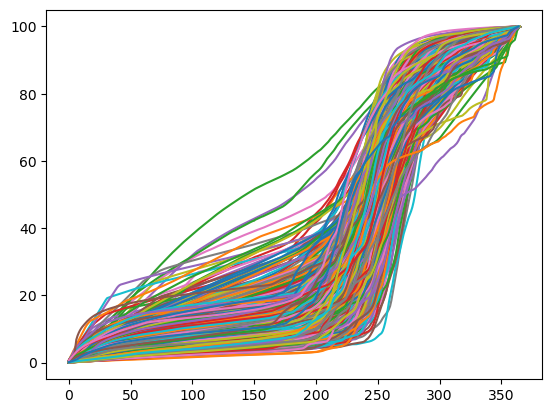

In [88]:
# calculate the length of the interquartile range for each WY at each site_no
high_elevation_df = pd.DataFrame(columns=high_elevation_daily_q.site_no.values, index=high_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in high_elevation_daily_q.site_no.values:
    tmp_ds = high_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique()[tmp_ds_filter.WY.to_pandas().unique() >= 1964]:
        high_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

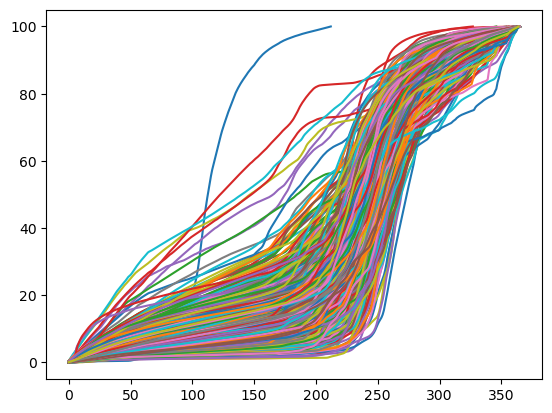

In [89]:
# calculate the length of the interquartile range for each WY at each site_no
mid_elevation_df = pd.DataFrame(columns=mid_elevation_daily_q.site_no.values, index=mid_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in mid_elevation_daily_q.site_no.values:
    tmp_ds = mid_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique()[tmp_ds_filter.WY.to_pandas().unique() >= 1964]:
        mid_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

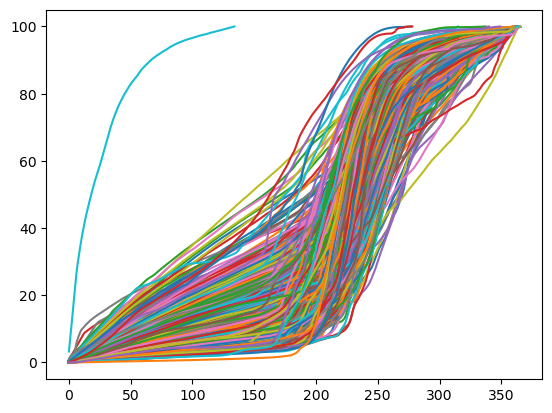

In [90]:
# calculate the length of the interquartile range for each WY at each site_no
low_elevation_df = pd.DataFrame(columns=low_elevation_daily_q.site_no.values, index=low_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in low_elevation_daily_q.site_no.values:
    tmp_ds = low_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique()[tmp_ds_filter.WY.to_pandas().unique() >= 1964]:
        low_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

In [91]:
# filter out the 5% and 95% percentiles of each columnn for the low_elevation_df
low_elevation_df_filtered = low_elevation_df.apply(lambda x: x[(x>=x.quantile(.05)) & (x<=x.quantile(.95))], axis=0)
# filter out the 5% and 95% percentiles of each columnn for the mid_elevation_df
mid_elevation_df_filtered = mid_elevation_df.apply(lambda x: x[(x>=x.quantile(.05)) & (x<=x.quantile(.95))], axis=0)

conf = 0.10

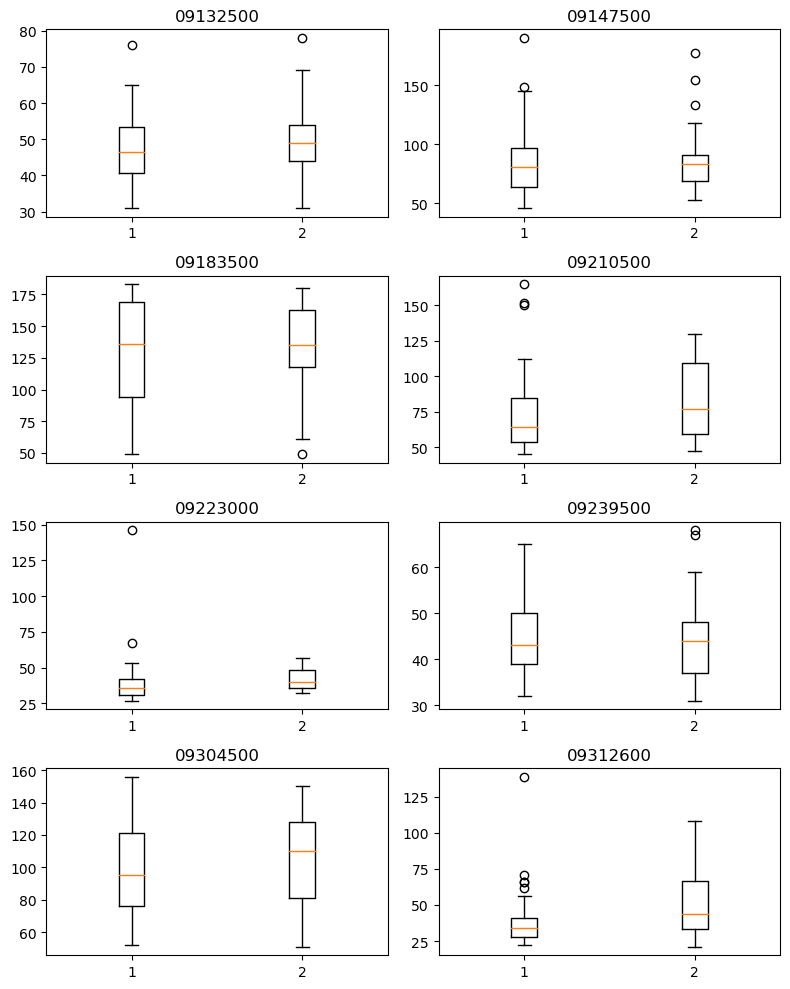

In [99]:
low_iqr_length_ttest = pd.DataFrame(index=low_elevation_df_filtered.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'mean difference',])
fig, axs = plt.subplots(4,2, figsize=(8,10), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(low_elevation_df.columns):
    single_site_pre = low_elevation_df[site].dropna().loc[:1999]
    single_site_post = low_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(1-conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        low_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            low_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        low_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value  < conf:
            low_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_iqr_length_ttest.loc[site,'mean difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [100]:
low_iqr_length_ttest

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,mean difference
09132500,0.240904,Probably Gaussian,0.208,Null Hypothesis Accepted,NaN,NaN,2.24
09147500,0.00178,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.277,Null Hypothesis Accepted,3.51
09183500,0.229289,Probably Gaussian,0.5,Null Hypothesis Accepted,NaN,NaN,0.0
09210500,0.00002,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.071,Null Hypothesis Rejected,7.01
09223000,0.0,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.019,Null Hypothesis Rejected,0.85
09239500,0.033671,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.598,Null Hypothesis Accepted,0.09
09304500,0.179653,Probably Gaussian,0.133,Null Hypothesis Accepted,NaN,NaN,8.52
09312600,0.0,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.027,Null Hypothesis Rejected,10.79


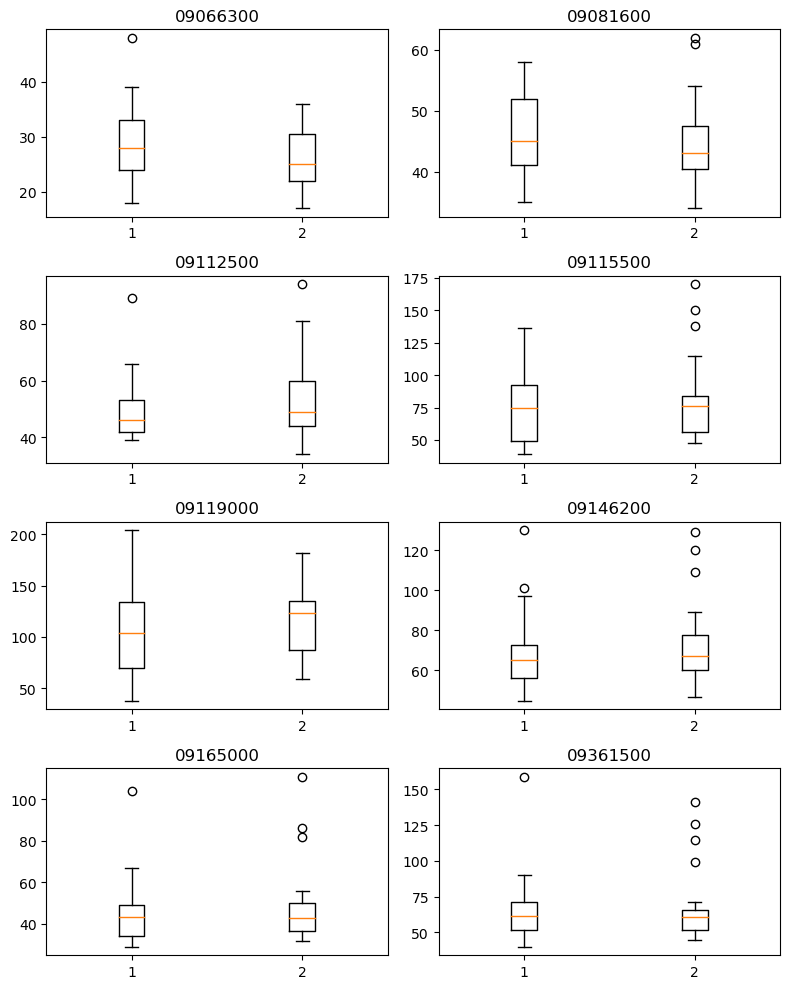

In [102]:
mid_iqr_length_ttest = pd.DataFrame(index=mid_elevation_df_filtered.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'mean difference'])
fig, axs = plt.subplots(4,2, figsize=(8,10), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(mid_elevation_df.columns):
    single_site_pre = mid_elevation_df[site].dropna().loc[:1999]
    single_site_post = mid_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(1-conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        mid_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            mid_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        mid_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_iqr_length_ttest.loc[site,'mean difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [103]:
mid_iqr_length_ttest

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,mean difference
09066300,0.116672,Probably Gaussian,0.955,Null Hypothesis Rejected,NaN,NaN,-2.78
09081600,0.024666,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.811,Null Hypothesis Accepted,-1.66
09112500,0.000035,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.123,Null Hypothesis Accepted,4.24
09115500,0.376934,Probably Gaussian,0.274,Null Hypothesis Accepted,NaN,NaN,5.85
09119000,0.114292,Probably Gaussian,0.201,Null Hypothesis Accepted,NaN,NaN,8.69
09146200,0.000852,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.135,Null Hypothesis Accepted,6.28
09165000,0.000034,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.217,Null Hypothesis Accepted,4.06
09361500,0.000002,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.562,Null Hypothesis Accepted,3.68


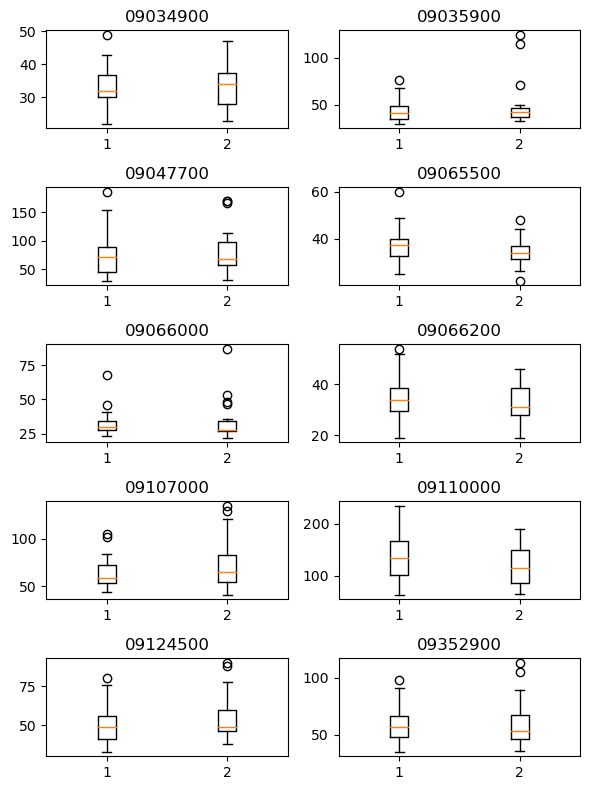

In [104]:
high_iqr_length_ttest = pd.DataFrame(index=high_elevation_df.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'mean difference'])
fig, axs = plt.subplots(5,2, figsize=(6,8), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(high_elevation_df.columns):
    single_site_pre = high_elevation_df[site].dropna().loc[:1999]
    single_site_post = high_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(1-conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        high_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_iqr_length_ttest.loc[site,'mean difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [105]:
high_iqr_length_ttest

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,mean difference
09034900,0.08511,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.378,Null Hypothesis Accepted,0.67
09035900,0.001471,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.29,Null Hypothesis Accepted,4.66
09047700,0.003556,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.249,Null Hypothesis Accepted,5.89
09065500,0.025971,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.962,Null Hypothesis Accepted,-2.86
09066000,0.000004,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.694,Null Hypothesis Accepted,1.68
09066200,0.391602,Probably Gaussian,0.84,Null Hypothesis Accepted,NaN,NaN,-1.95
09107000,0.06371,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.313,Null Hypothesis Accepted,6.18
09110000,0.156409,Probably Gaussian,0.974,Null Hypothesis Rejected,NaN,NaN,-21.6
09124500,0.036094,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.192,Null Hypothesis Accepted,4.07
09352900,0.161926,Probably Gaussian,0.32,Null Hypothesis Accepted,NaN,NaN,2.27


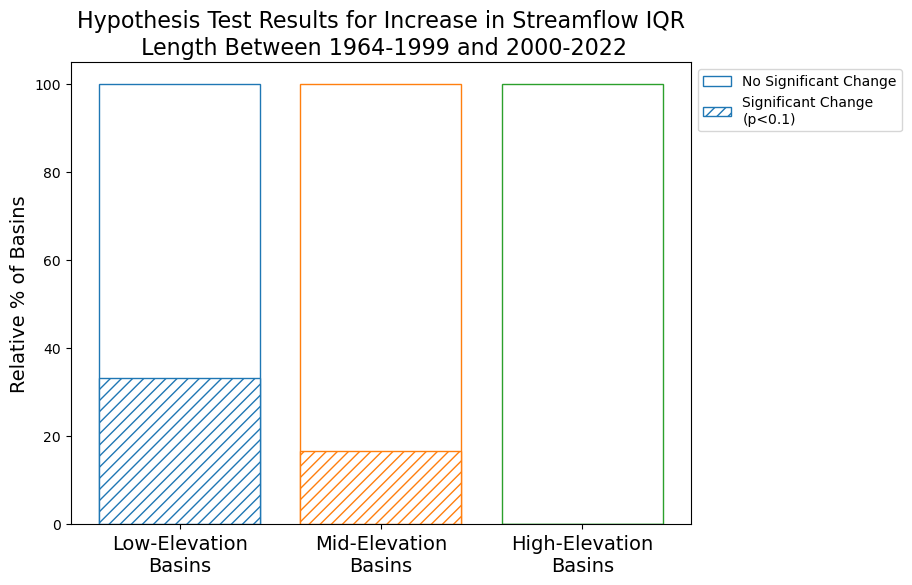

In [41]:

# create a dataframe with the results
low_rejected = len(low_iqr_length_ttest[(low_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_iqr_length_ttest['mannwhitney p']<0.1)])
mid_rejected = len(mid_iqr_length_ttest[(mid_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_iqr_length_ttest['mannwhitney p']<0.1)])
high_rejected = len(high_iqr_length_ttest[(high_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_iqr_length_ttest['mannwhitney p']<0.1)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.1)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Increase in Streamflow IQR\n Length Between {1964}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)

(0.0, 13.0)

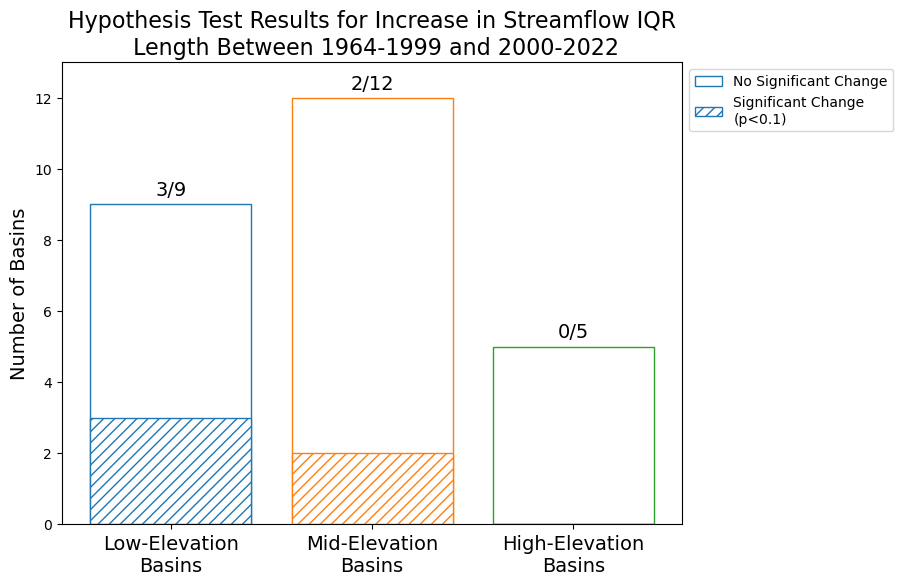

In [42]:

# create a dataframe with the results
low_rejected = len(low_iqr_length_ttest[(low_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_iqr_length_ttest['mannwhitney p']<0.1)])
mid_rejected = len(mid_iqr_length_ttest[(mid_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_iqr_length_ttest['mannwhitney p']<0.1)])
high_rejected = len(high_iqr_length_ttest[(high_iqr_length_ttest['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_iqr_length_ttest['mannwhitney p']<0.1)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[9, 12, 5], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[(low_rejected), (mid_rejected), (high_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.1)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Increase in Streamflow IQR\n Length Between {1964}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.set_ylim(0,13)

# <a id='toc2_'></a>[Calculate additional metrics for summer precipitation changes](#toc0_)

### <a id='toc2_1_1_'></a>[Look to see if summer streamflow variability is decreasing](#toc0_)

In [43]:
# get the summer streamflow values for june, july, august, and september
summer_streamflow = hcdn_q_data.where(hcdn_q_data.date.dt.month.isin([7,8,9]), drop=True)

# calculate the annual coefficient of variability for summer streamflow for each site_no
summer_streamflow_annual_cv = summer_streamflow.groupby('site_no').apply(lambda x: x.groupby('WY').apply(lambda y: y.q_mm_day.std()/y.q_mm_day.mean()))
summer_streamflow_annual_cv_pre = summer_streamflow_annual_cv.sel(WY=slice(1964,1999))
summer_streamflow_annual_cv_post = summer_streamflow_annual_cv.sel(WY=slice(2000,2022))

In [44]:
pre_cv = (summer_streamflow_annual_cv_pre.to_dataframe()).reset_index(drop=False)
post_cv = (summer_streamflow_annual_cv_post.to_dataframe()).reset_index(drop=False)

# combine pre and post into a single dataframe
pre_post_cv = pre_cv.merge(post_cv, on='site_no', suffixes=('_pre','_post'))
df_melt = pre_post_cv.melt(id_vars='site_no',
                 value_vars=['q_mm_day_pre','q_mm_day_post'],
                 var_name='period',)

# rename q_mm_day_pre to 1964-1999 and q_mm_day_post to 2000-2022
df_melt['period'] = df_melt['period'].replace({'q_mm_day_pre':'1964-1999','q_mm_day_post':'2000-2022'})

# separate df_melt into mid, low, and high elevation dataframes
mid_elevation_df = df_melt[df_melt.site_no.isin(mid_elevation_daily_q.site_no.values)]
low_elevation_df = df_melt[df_melt.site_no.isin(low_elevation_daily_q.site_no.values)]
high_elevation_df = df_melt[df_melt.site_no.isin(high_elevation_daily_q.site_no.values)]


Text(0.5, 0.98, 'Coefficient of Variation for Summer Streamflow Between Periods')

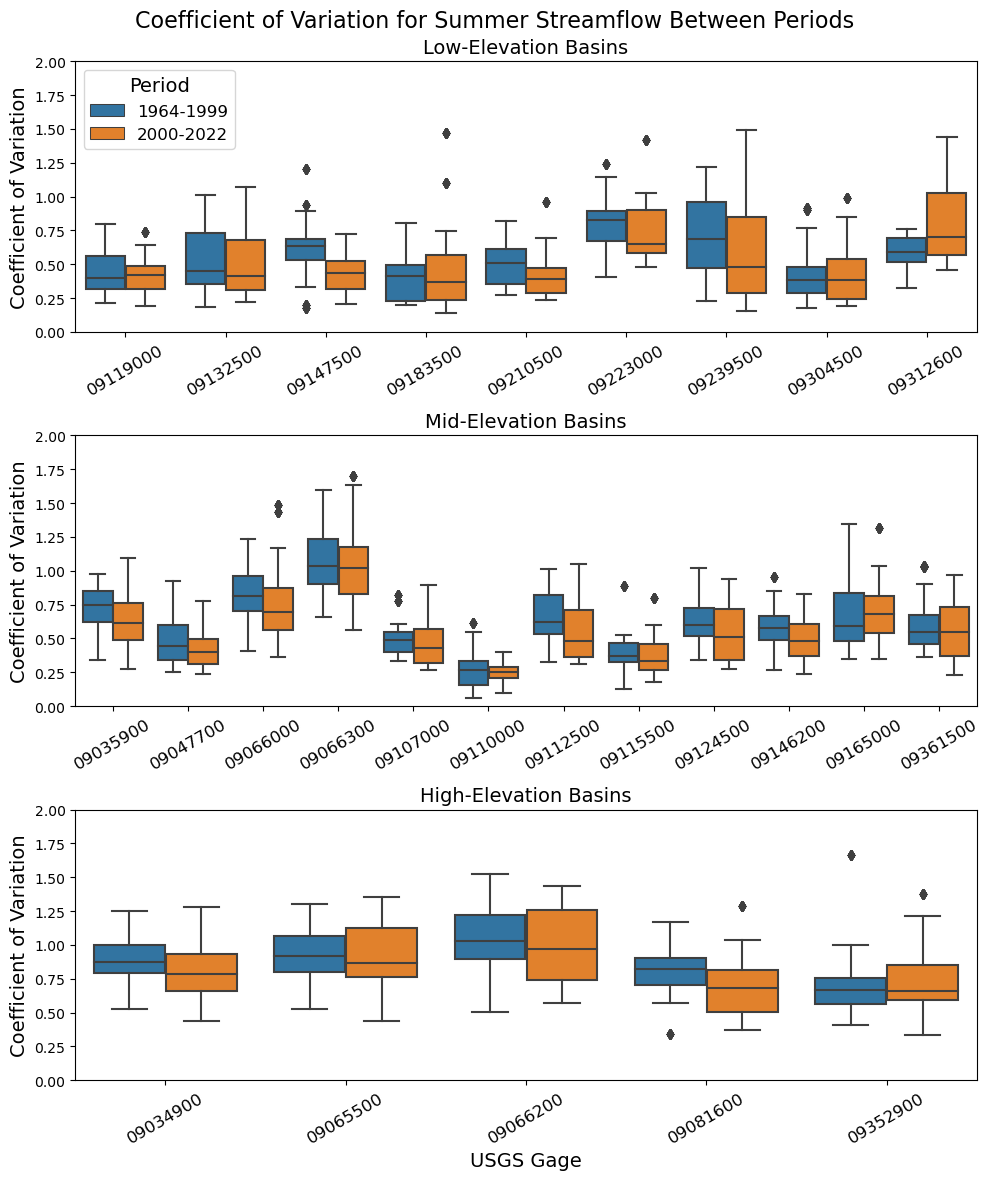

In [47]:
# create a boxplot of the coefficient of variability for each period for each elevation range
fig, axs = plt.subplots(3,1, figsize=(10,12), tight_layout=True)
# plot low elevation basins
sns.boxplot(data=low_elevation_df, x='site_no', y='value', hue='period', ax=axs[0])
axs[0].set_title('Low-Elevation Basins', size=14)
axs[0].legend(title='Period', title_fontsize=14, fontsize=12)

# plot mid elevation basins
sns.boxplot(data=mid_elevation_df, x='site_no', y='value', hue='period', ax=axs[1])
axs[1].set_title('Mid-Elevation Basins', size=14)
# remove legend for axs[1]
axs[1].get_legend().remove()

# plot high elevation basins
sns.boxplot(data=high_elevation_df, x='site_no', y='value', hue='period', ax=axs[2])
axs[2].set_title('High-Elevation Basins', size=14)
# remove legend for axs[2]
axs[2].get_legend().remove()

for ax in axs:
    # rotate the x-axis labels 90 degrees
    ax.tick_params(axis='x', rotation=30)
    # increase the size of the x-axis labels
    ax.tick_params(axis='x', labelsize=12)
    # set the y-axis label to "Coefficient of Variation"
    ax.set_ylabel('Coefficient of Variation', fontsize=14)
    # set ylim to 0,2
    ax.set_ylim(0,2)
    # Set the x-axis label to ""
    ax.set_xlabel("")
axs[2].set_xlabel('USGS Gage', fontsize=14)
    # Set title to be "Coefficient of Variation for Summer Streamflow Between Periods"
fig.suptitle('Coefficient of Variation for Summer Streamflow Between Periods', fontsize=16)

    


In [131]:
cv_summer_diff_ttest = pd.DataFrame(index=summer_streamflow_annual_cv.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])

conf = 0.10    
for i,site in enumerate(summer_streamflow_annual_cv.site_no.values):
    single_site_pre = pre_cv[pre_cv['site_no']==site]['q_mm_day'].dropna()
    single_site_post = post_cv[post_cv['site_no']==site]['q_mm_day'].dropna()

    # filter out the 5% and 95% percentiles of each columnn for the pre data
    single_site_pre = single_site_pre[(single_site_pre>=single_site_pre.quantile(.05)) & (single_site_pre<=single_site_pre.quantile(.95))]
    # filter out the 5% and 95% percentiles of each columnn for the mid_elevation_df
    single_site_post = single_site_post[(single_site_post>=single_site_post.quantile(.05)) & (single_site_post<=single_site_post.quantile(.95))]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    cv_summer_diff_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        cv_summer_diff_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        cv_summer_diff_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            cv_summer_diff_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            cv_summer_diff_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        cv_summer_diff_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='less')
        cv_summer_diff_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            cv_summer_diff_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            cv_summer_diff_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [133]:
cv_summer_diff_ttest[(cv_summer_diff_ttest['mannwhitney Result']=='Null Hypothesis Rejected') | 
                     (cv_summer_diff_ttest['t-test Result']=='Null Hypothesis Rejected')]

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.679148,Probably Gaussian,0.014,Null Hypothesis Rejected,NaN,NaN
09035900,0.847251,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09066000,0.668257,Probably Gaussian,0.019,Null Hypothesis Rejected,NaN,NaN
09081600,0.611039,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09124500,0.296657,Probably Gaussian,0.012,Null Hypothesis Rejected,NaN,NaN
09146200,0.470845,Probably Gaussian,0.017,Null Hypothesis Rejected,NaN,NaN
09147500,0.38128,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN
09165000,0.001599,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.052,Null Hypothesis Rejected
09223000,0.145292,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN
09239500,0.435997,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN


### <a id='toc2_1_2_'></a>[Using Thortwaithe method for monthly ET estimates](#toc0_)

ModuleNotFoundError: No module named 'pyeto'